In [2]:
from music21 import converter

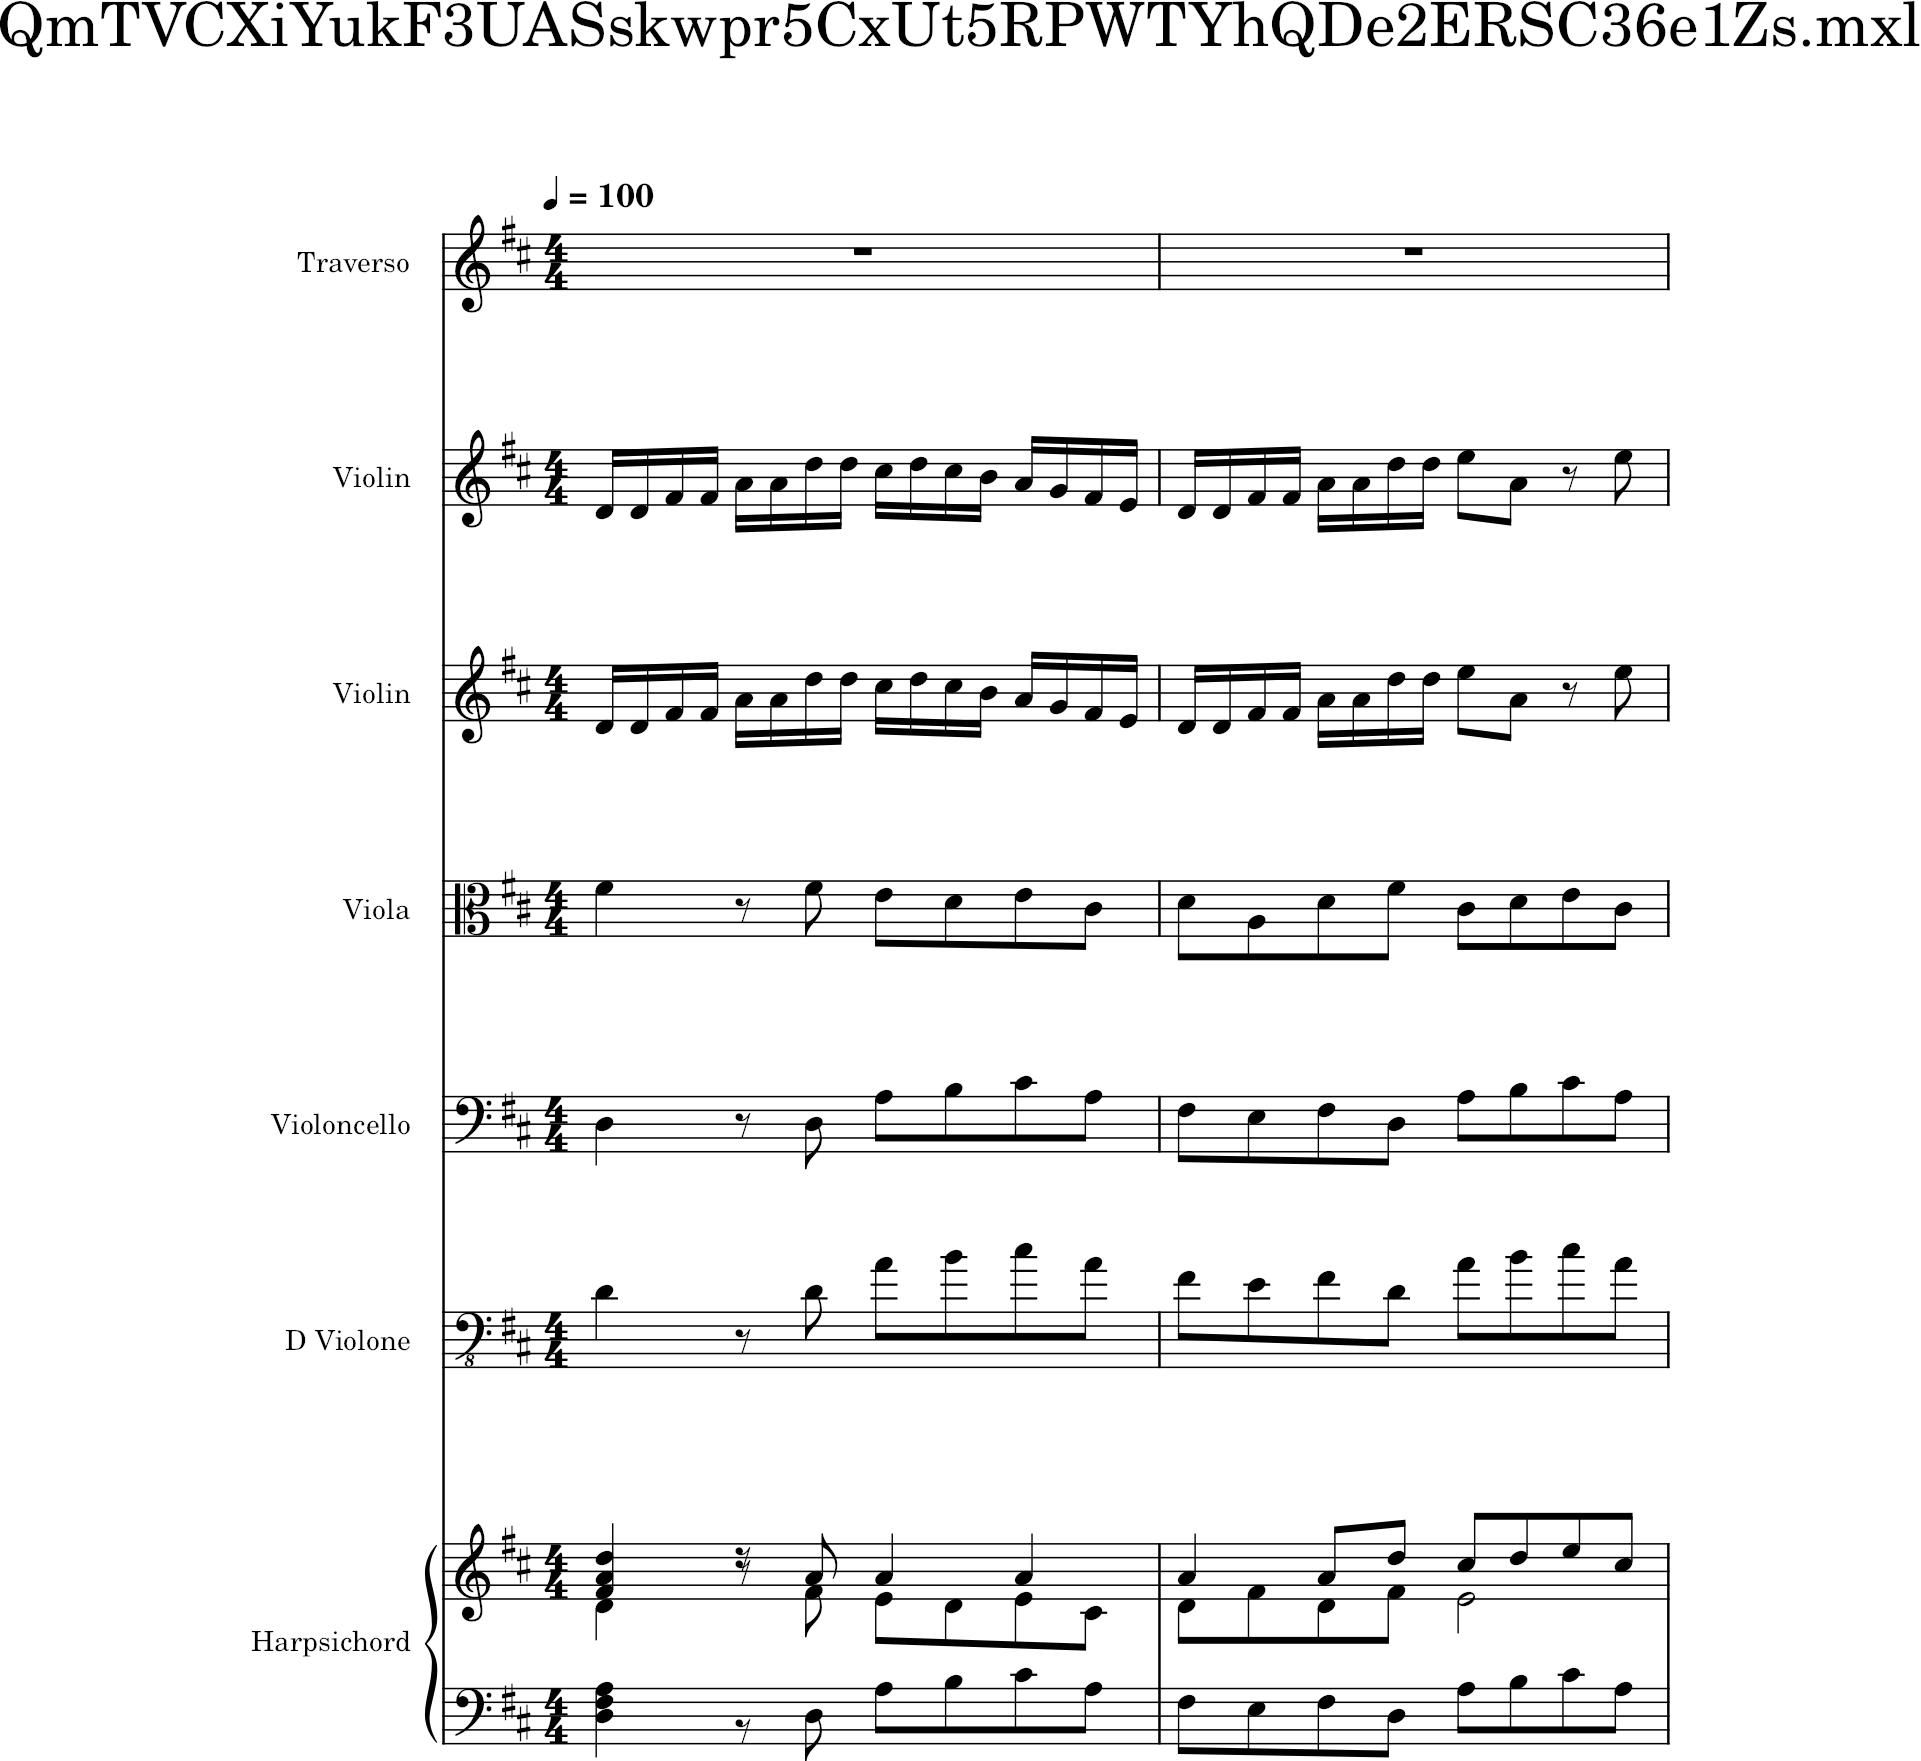

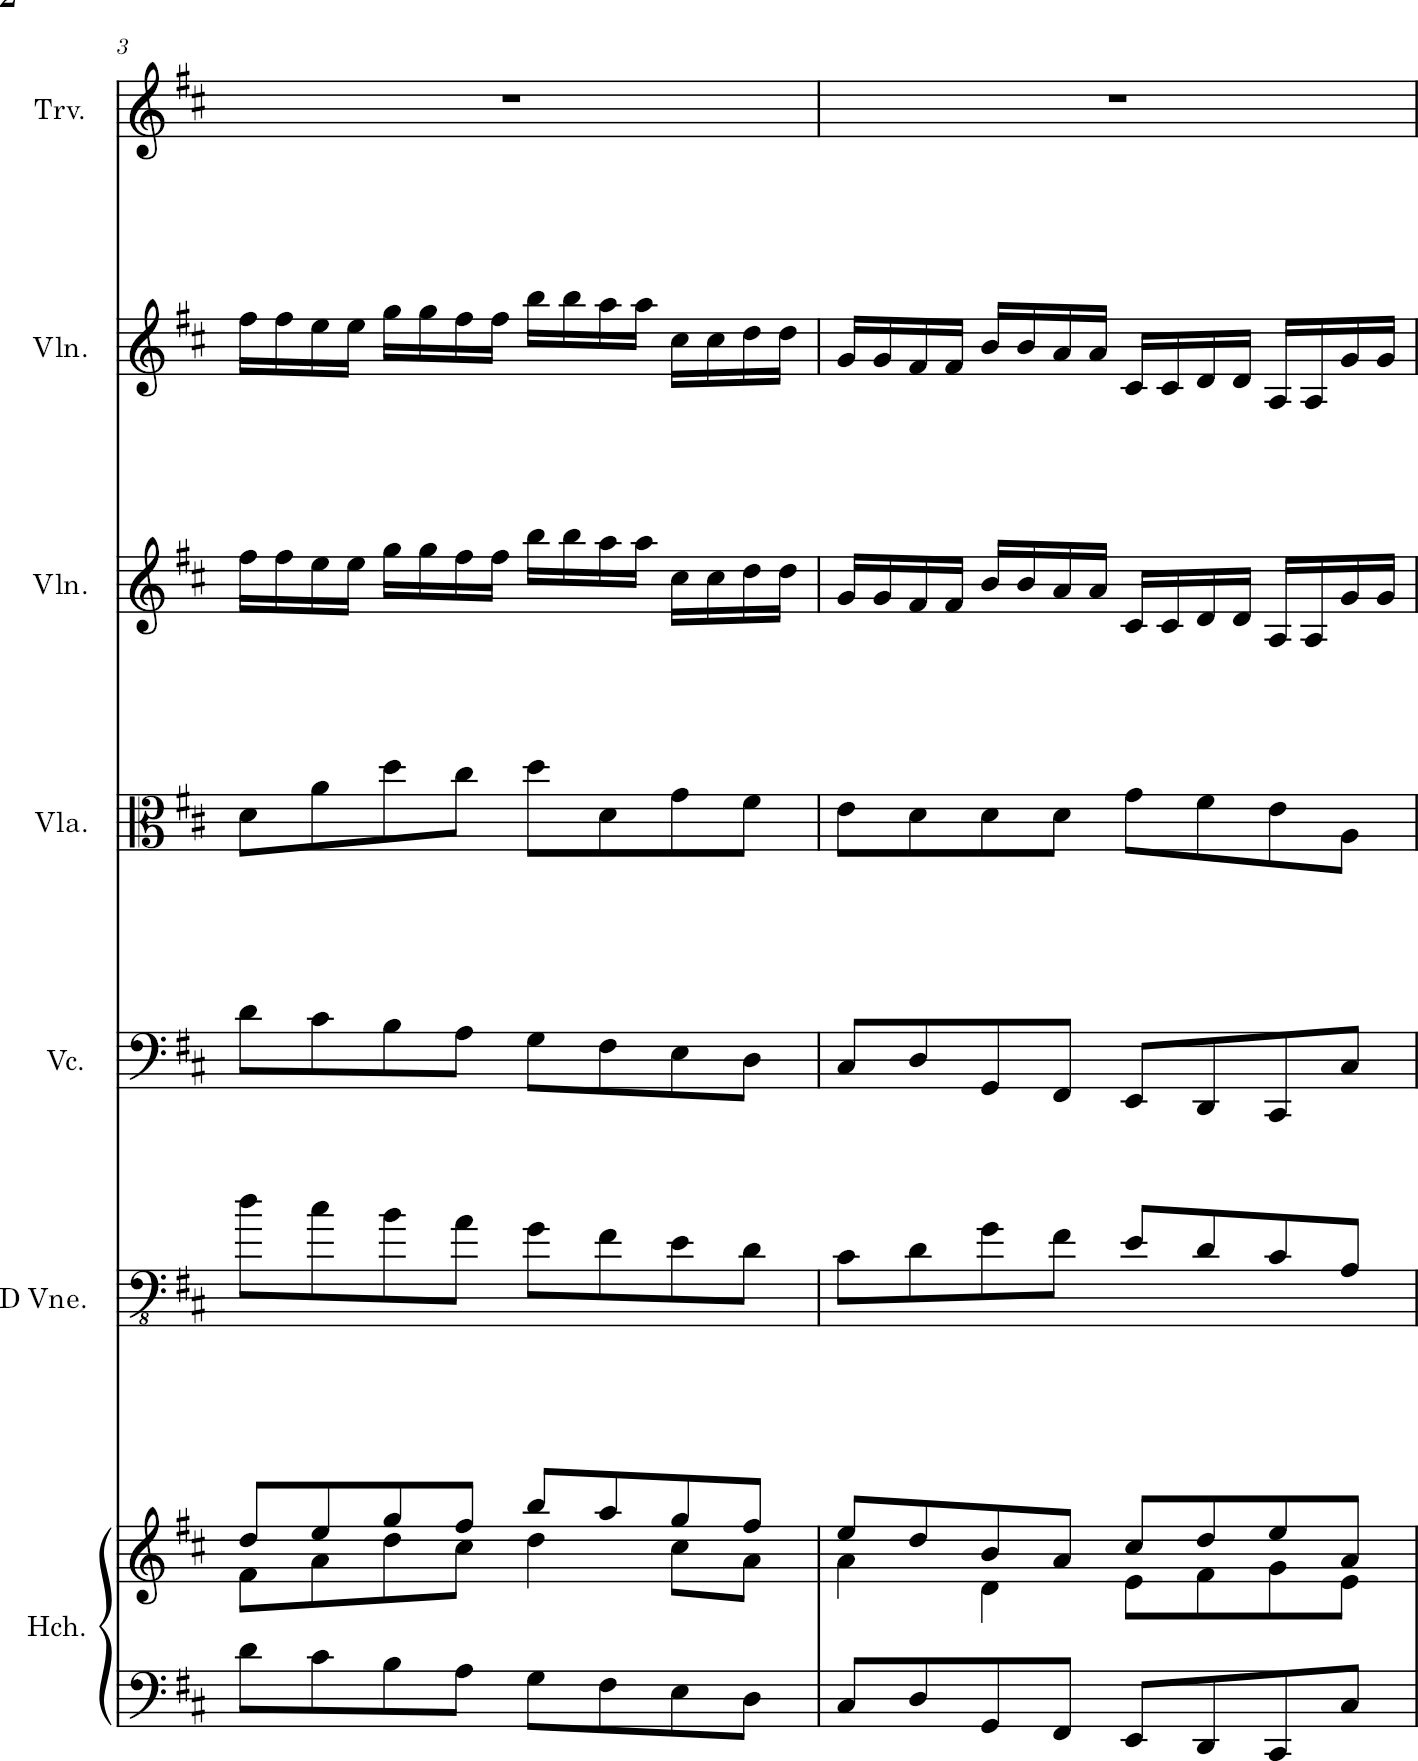

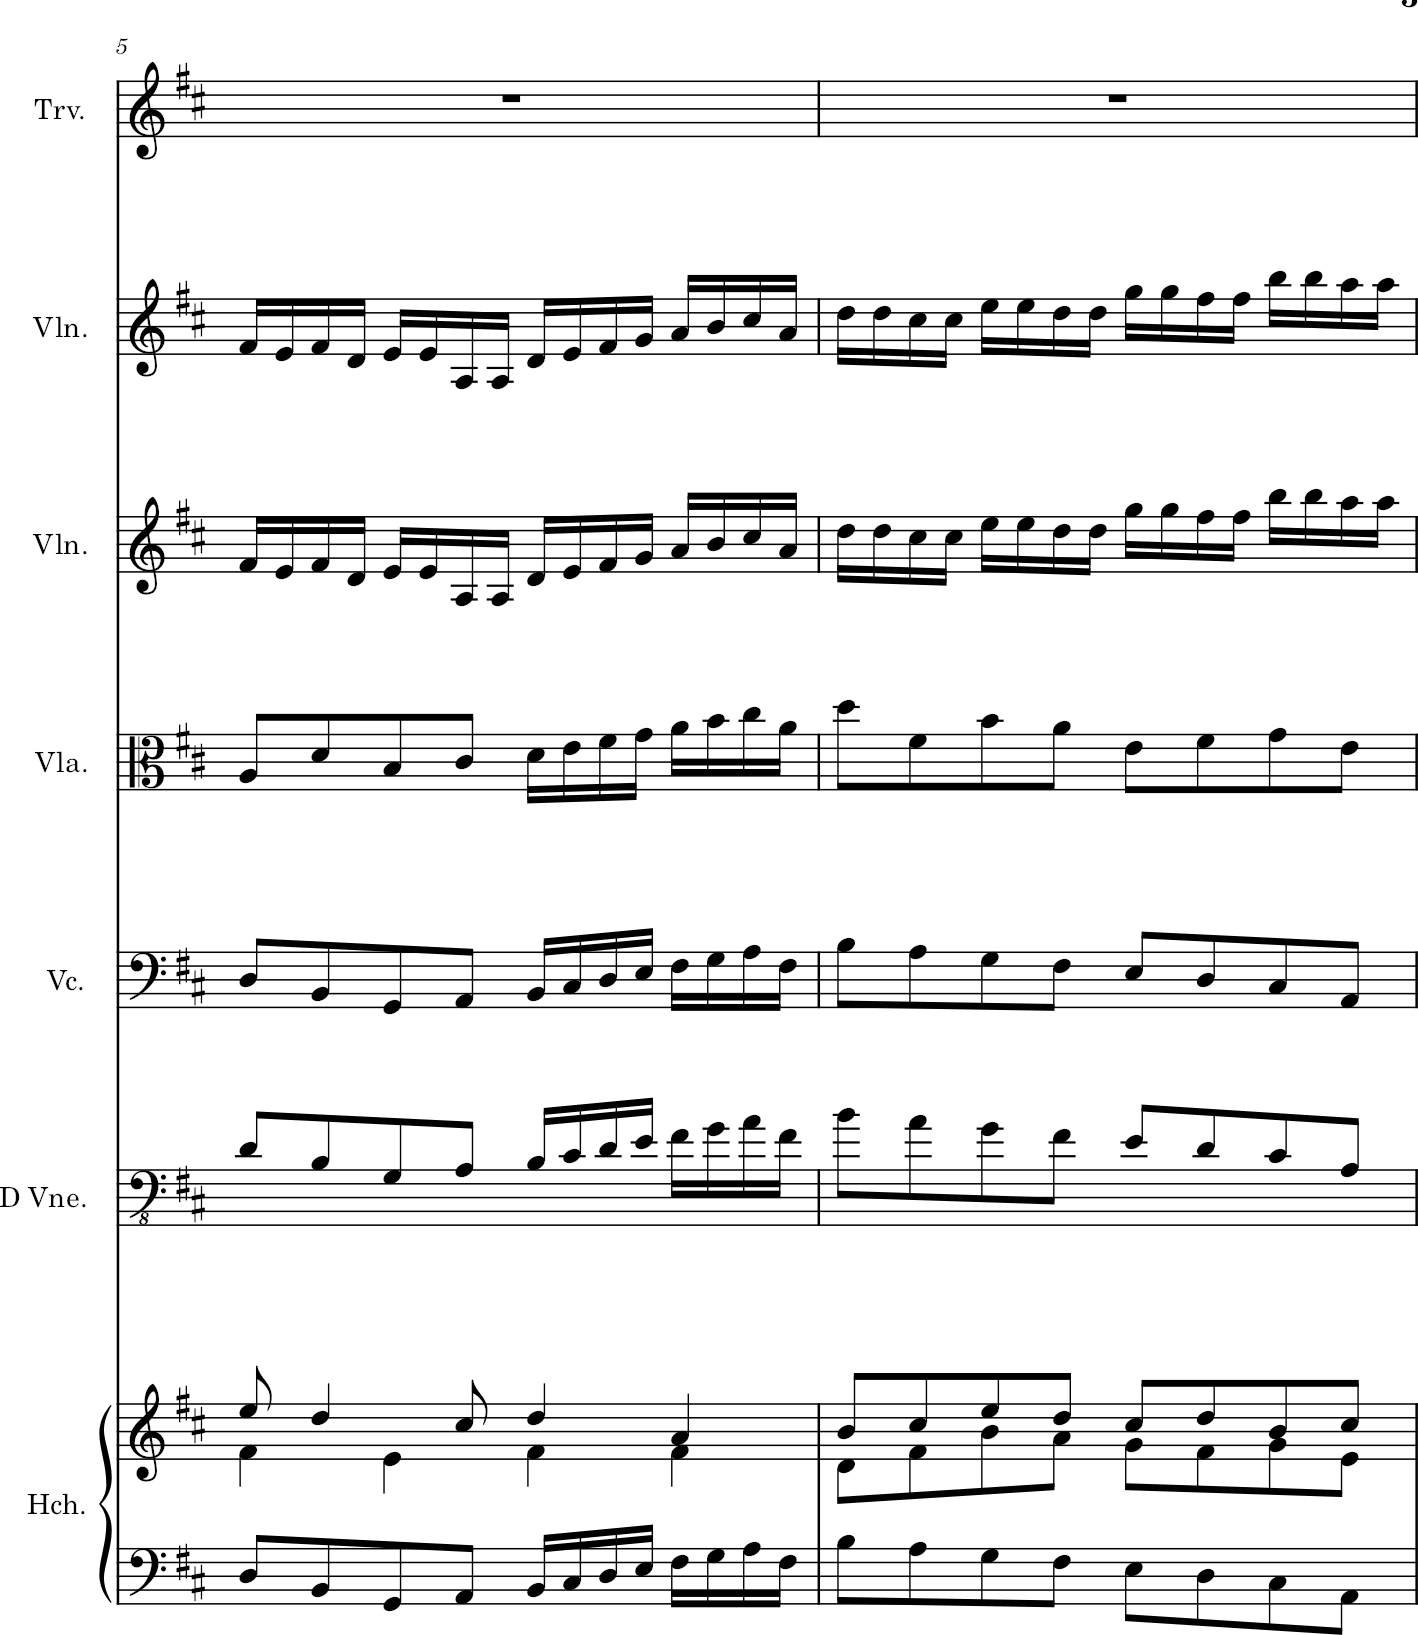

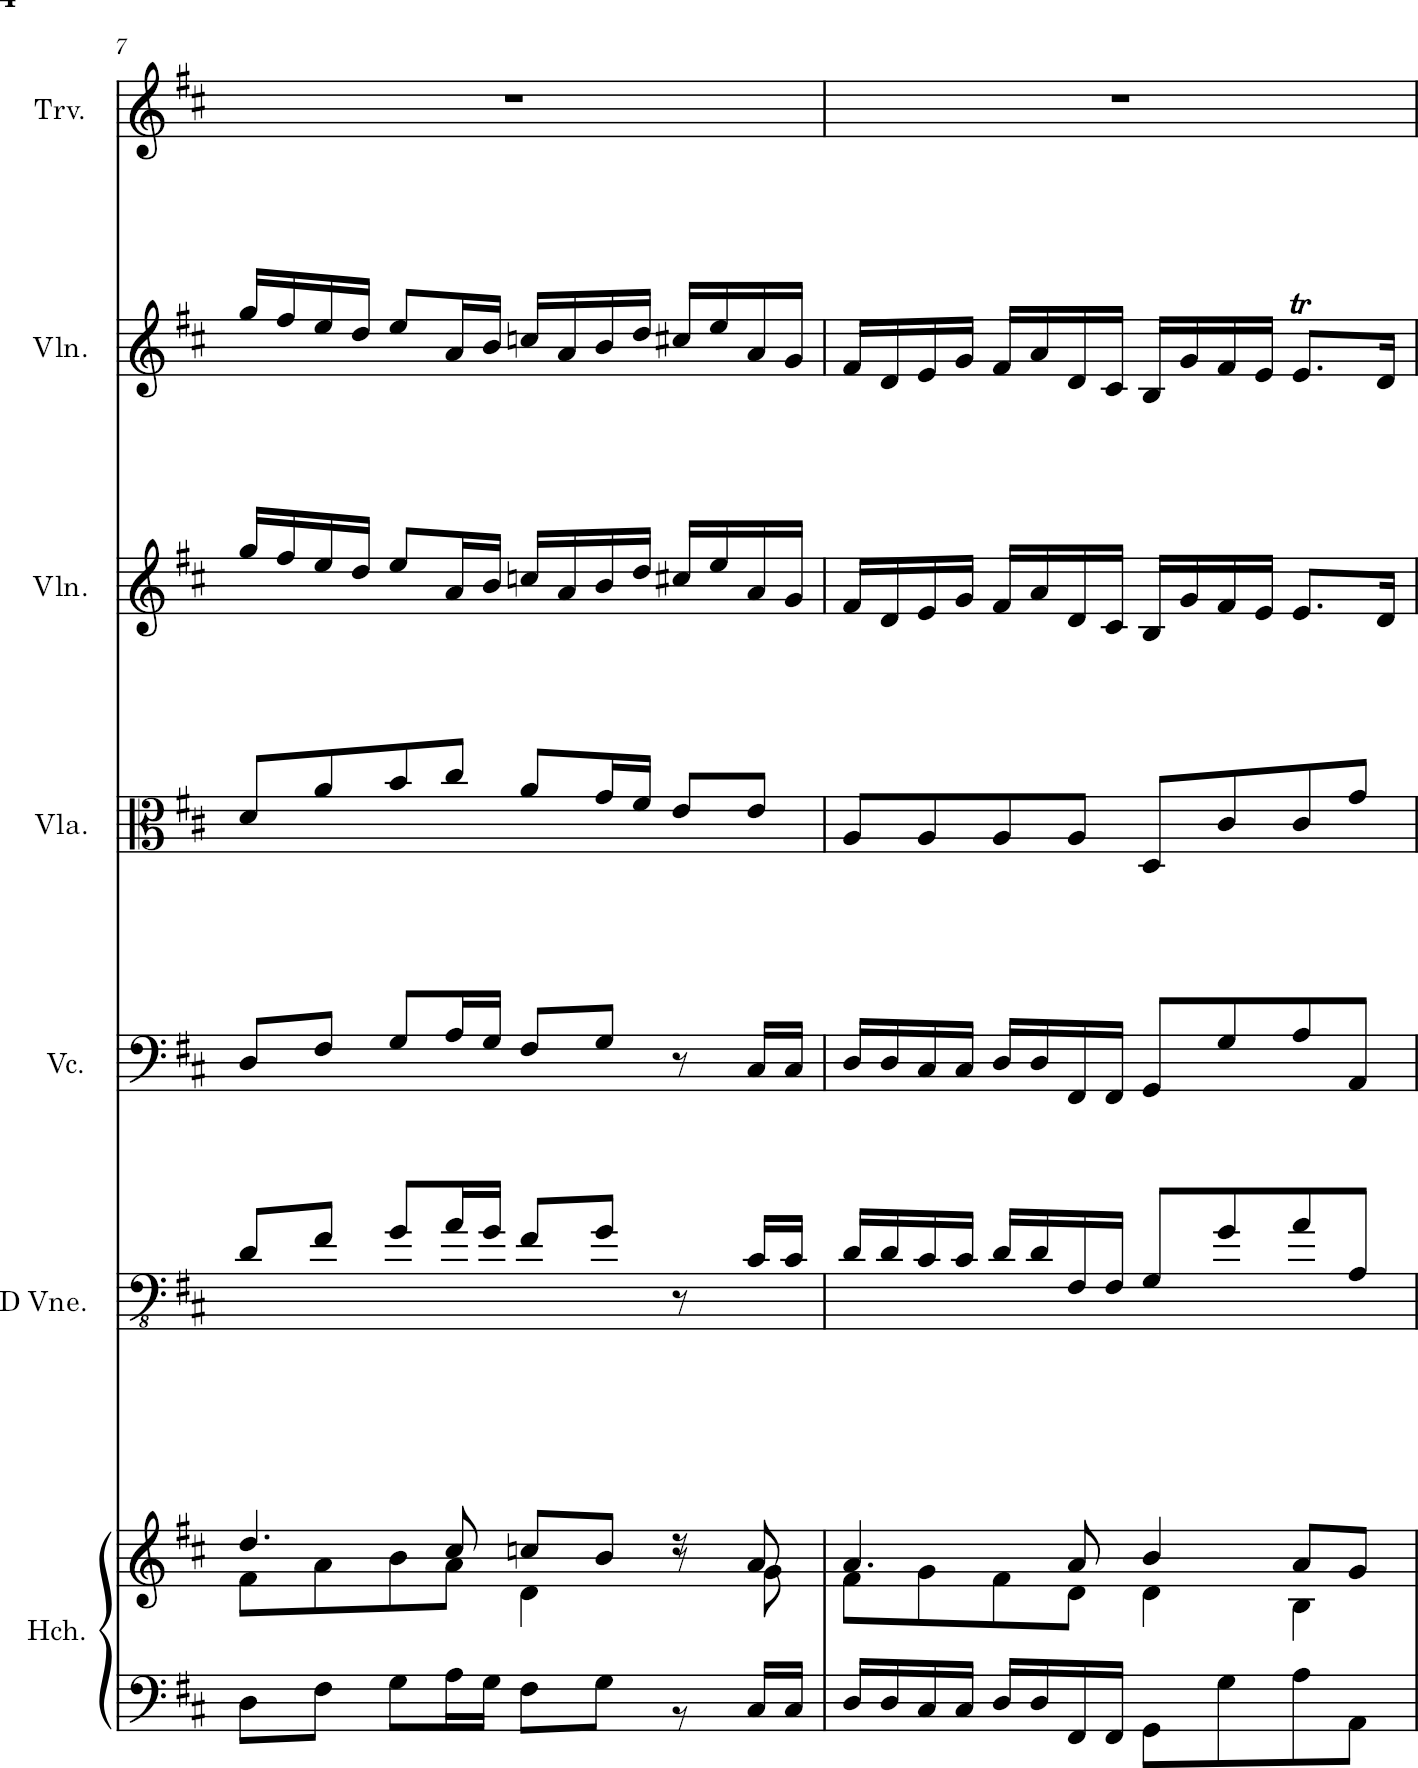

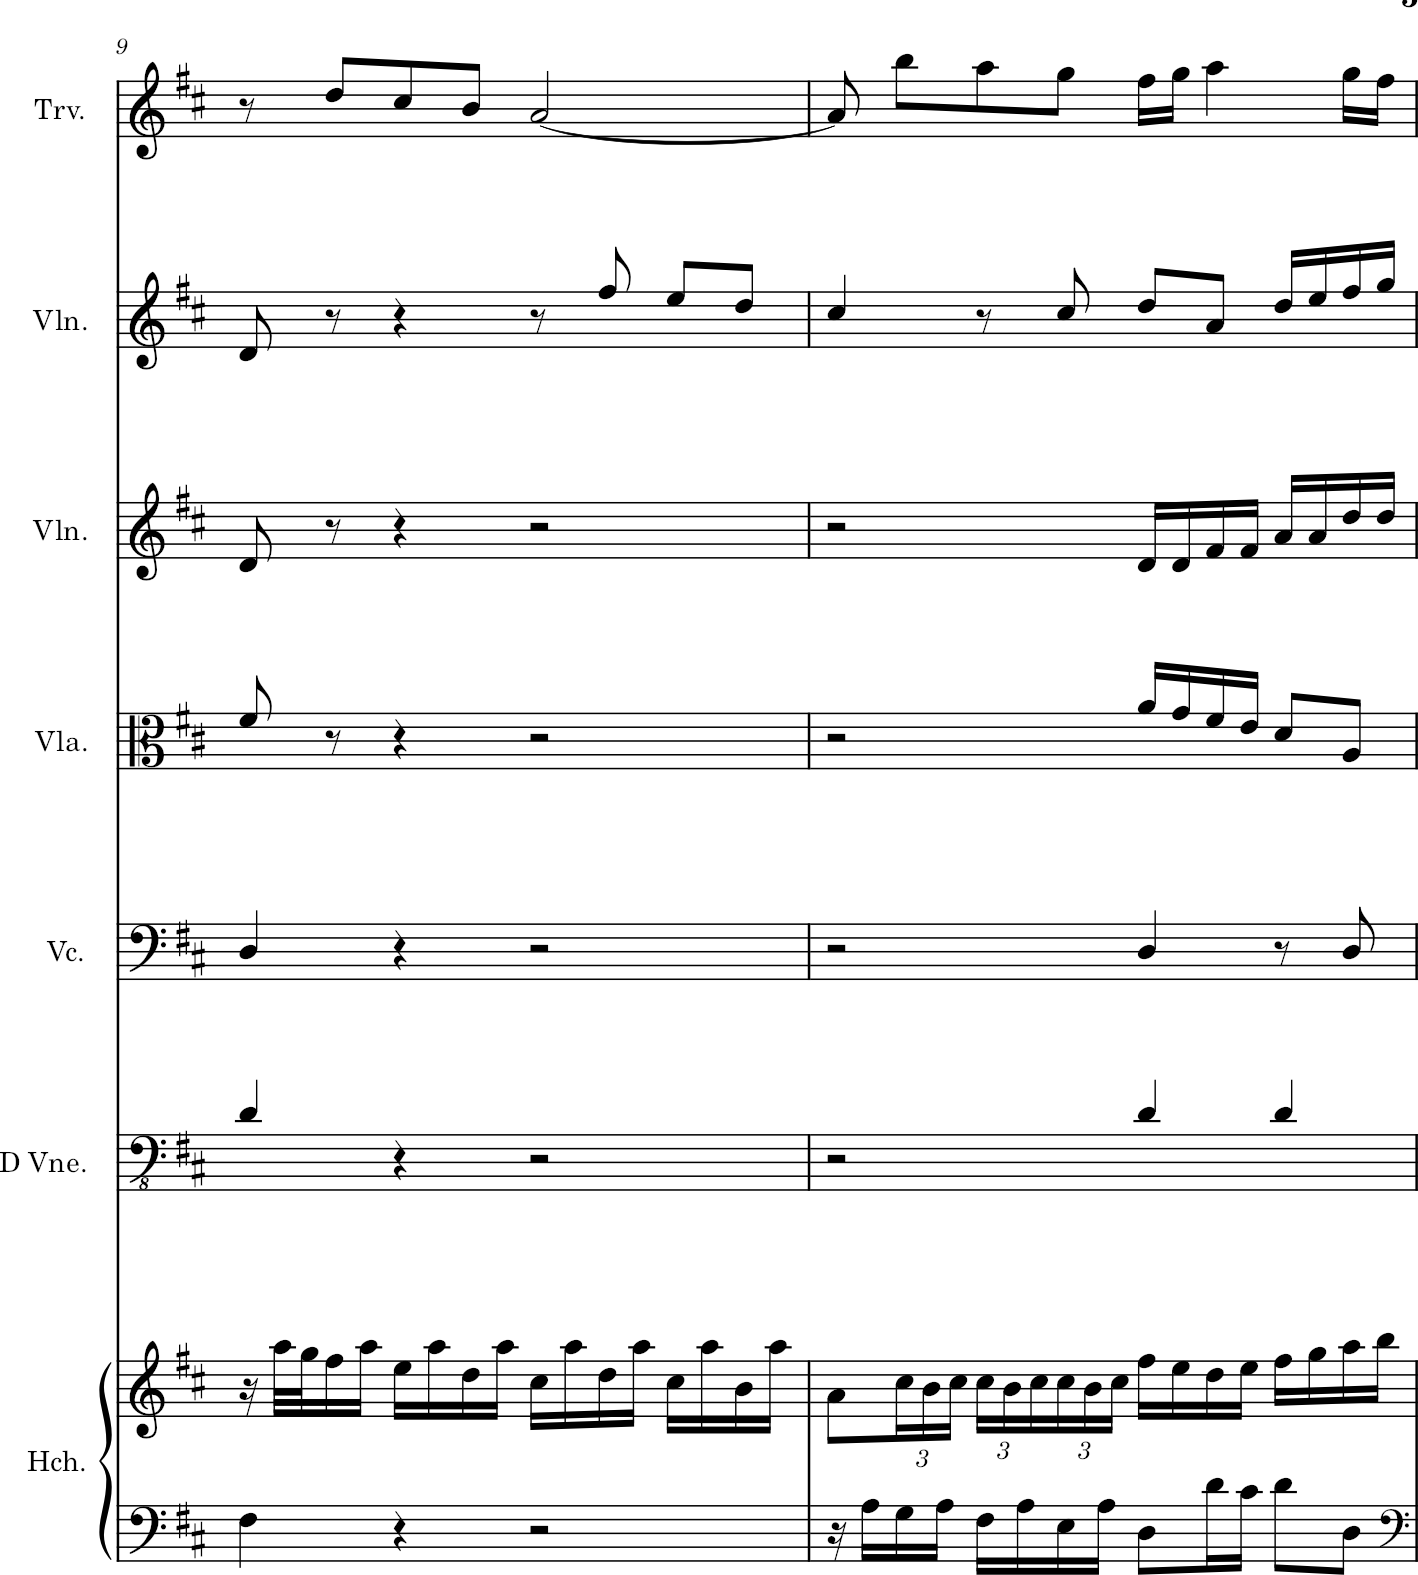

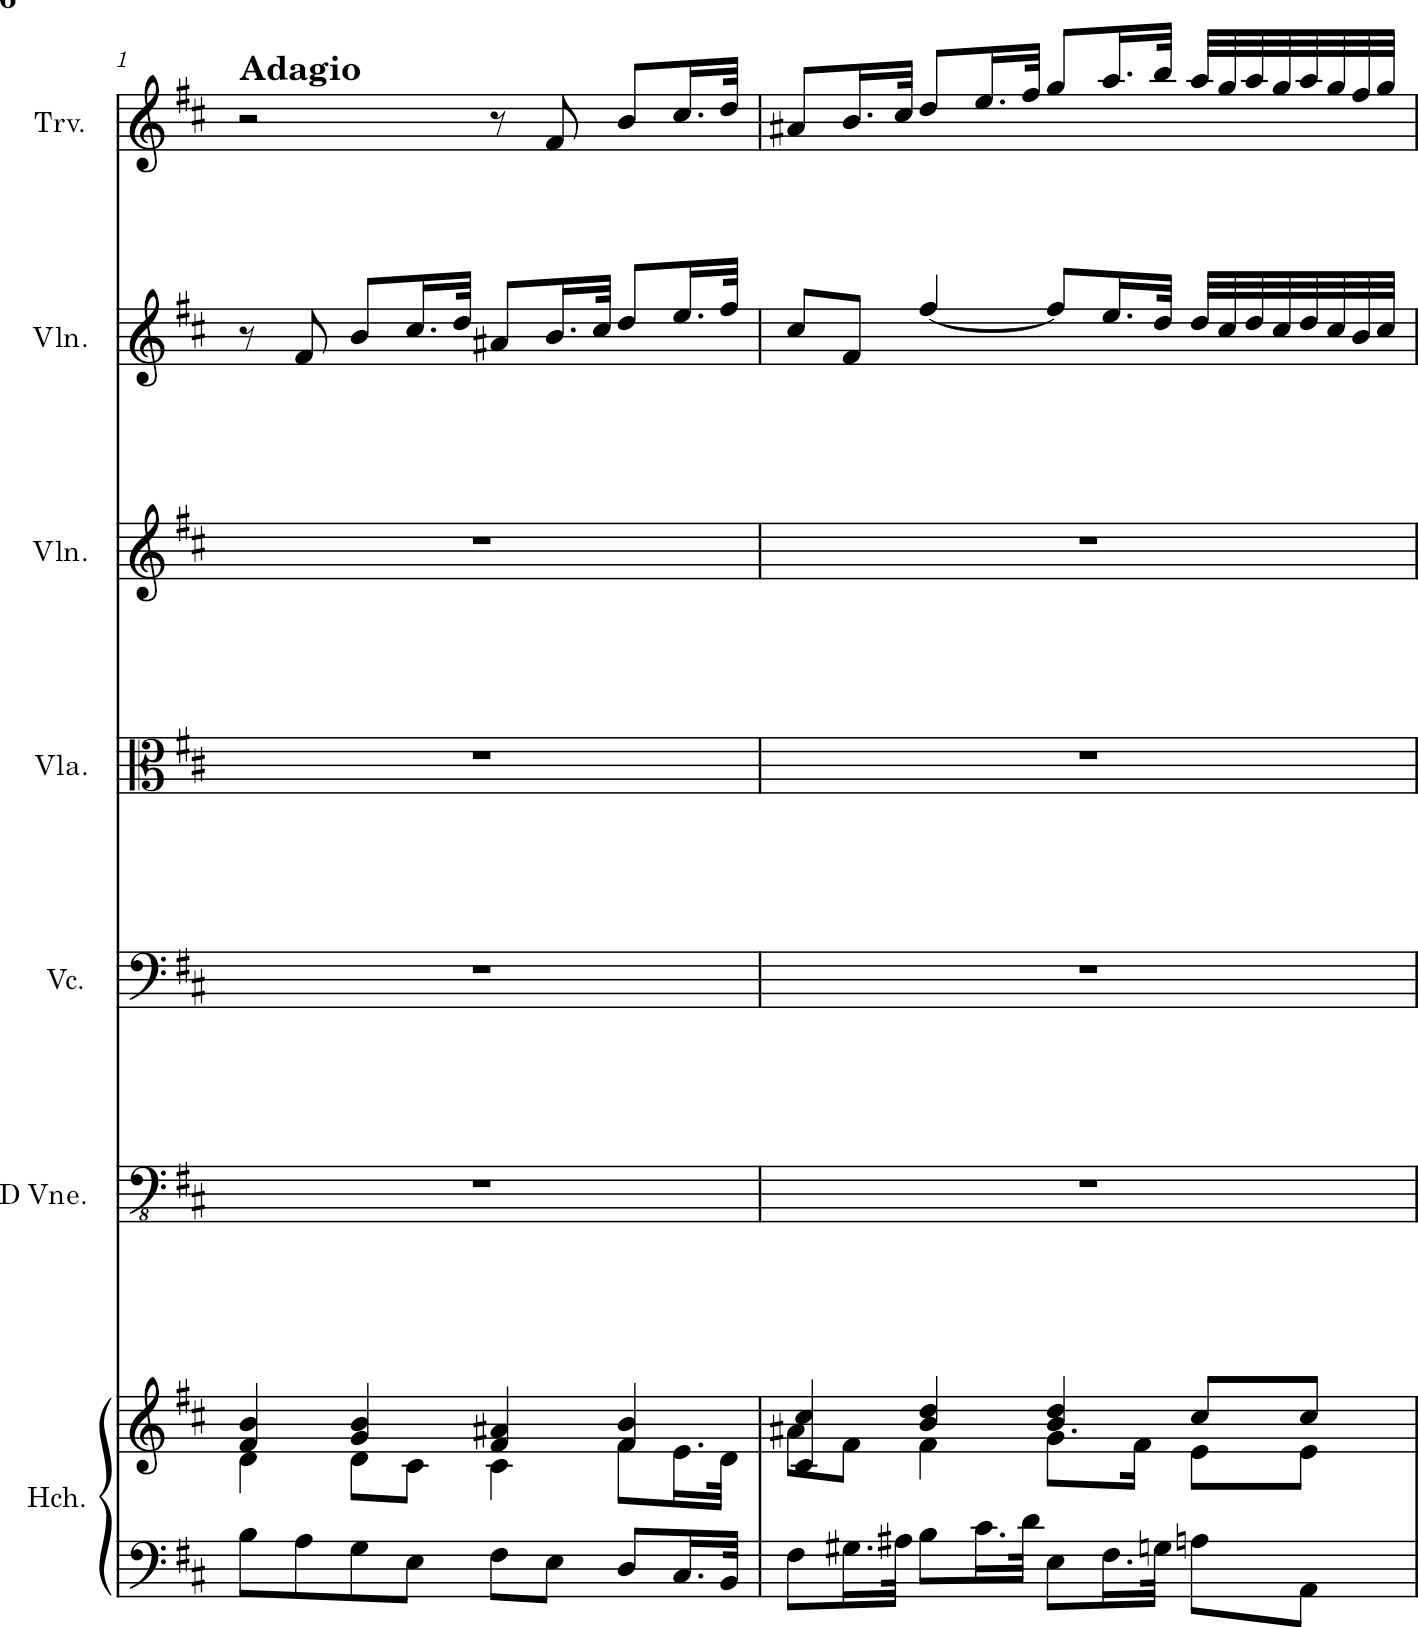

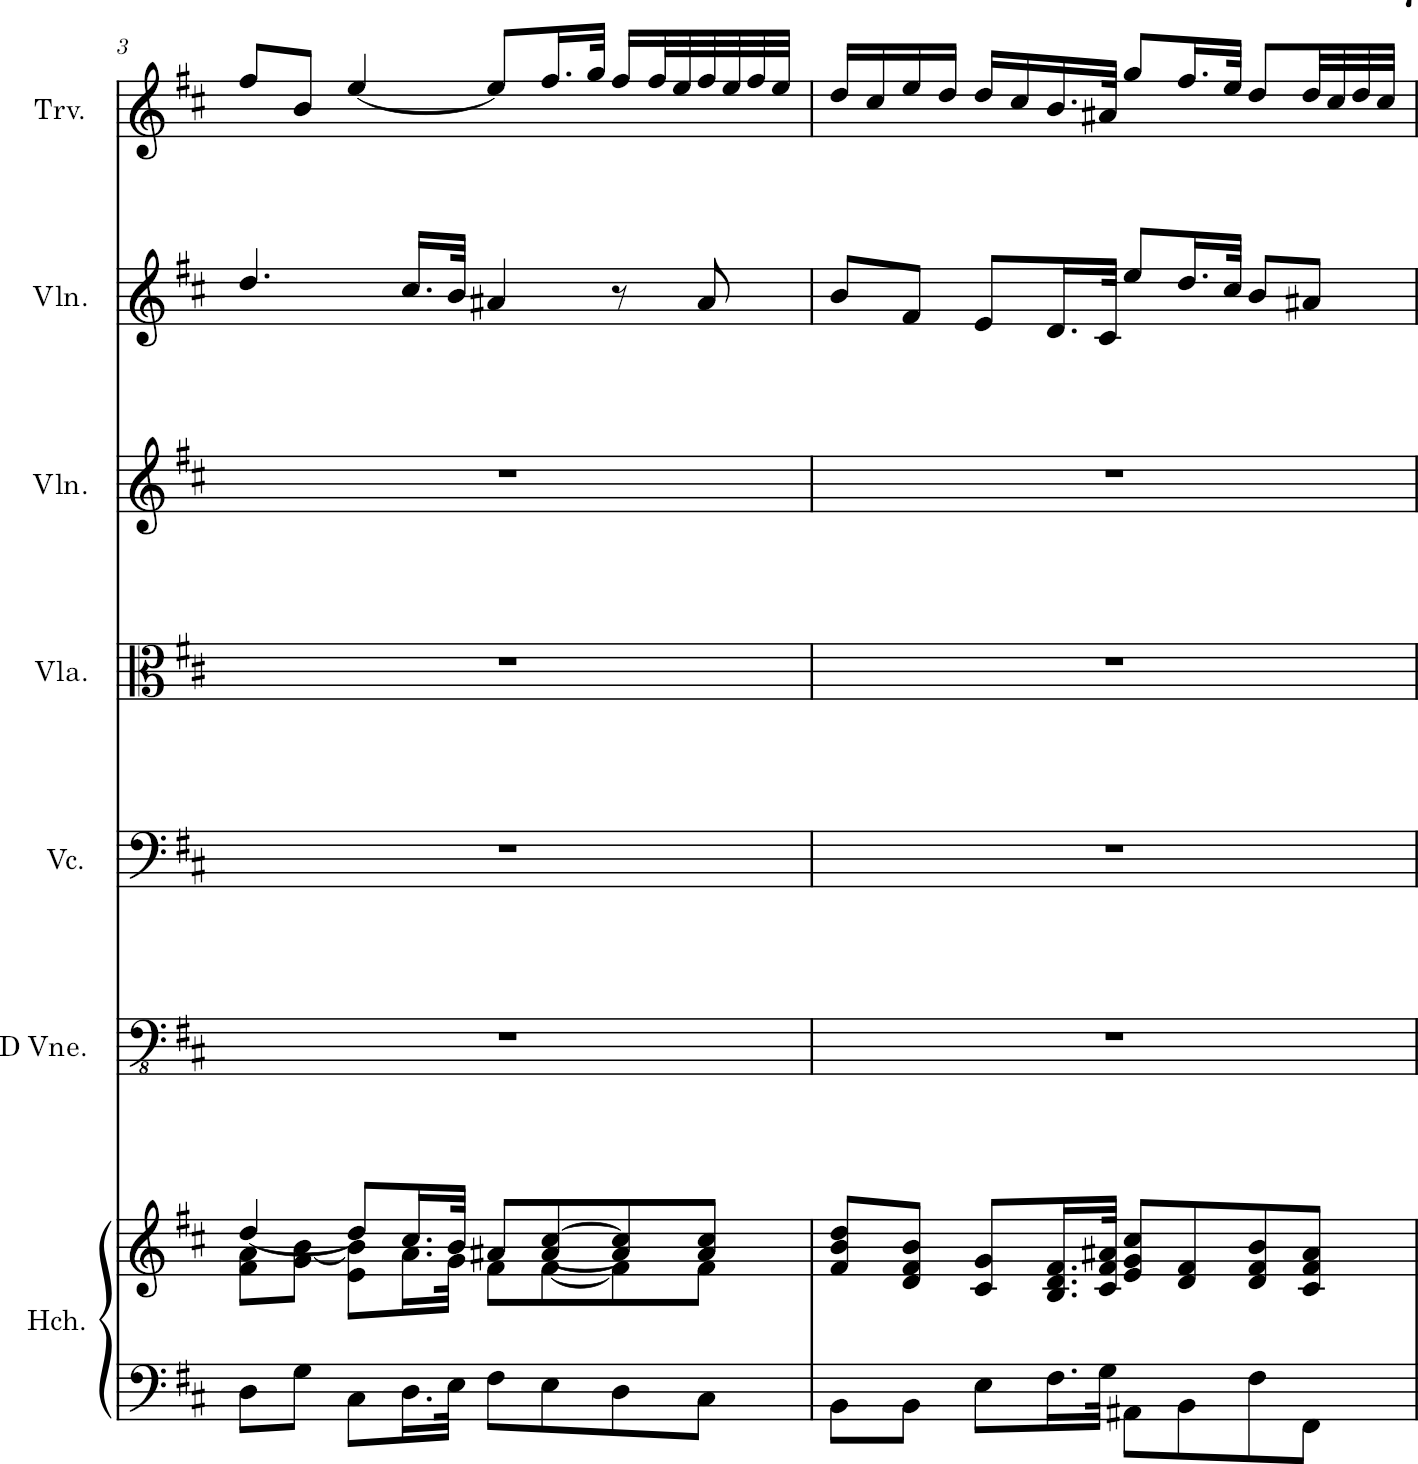

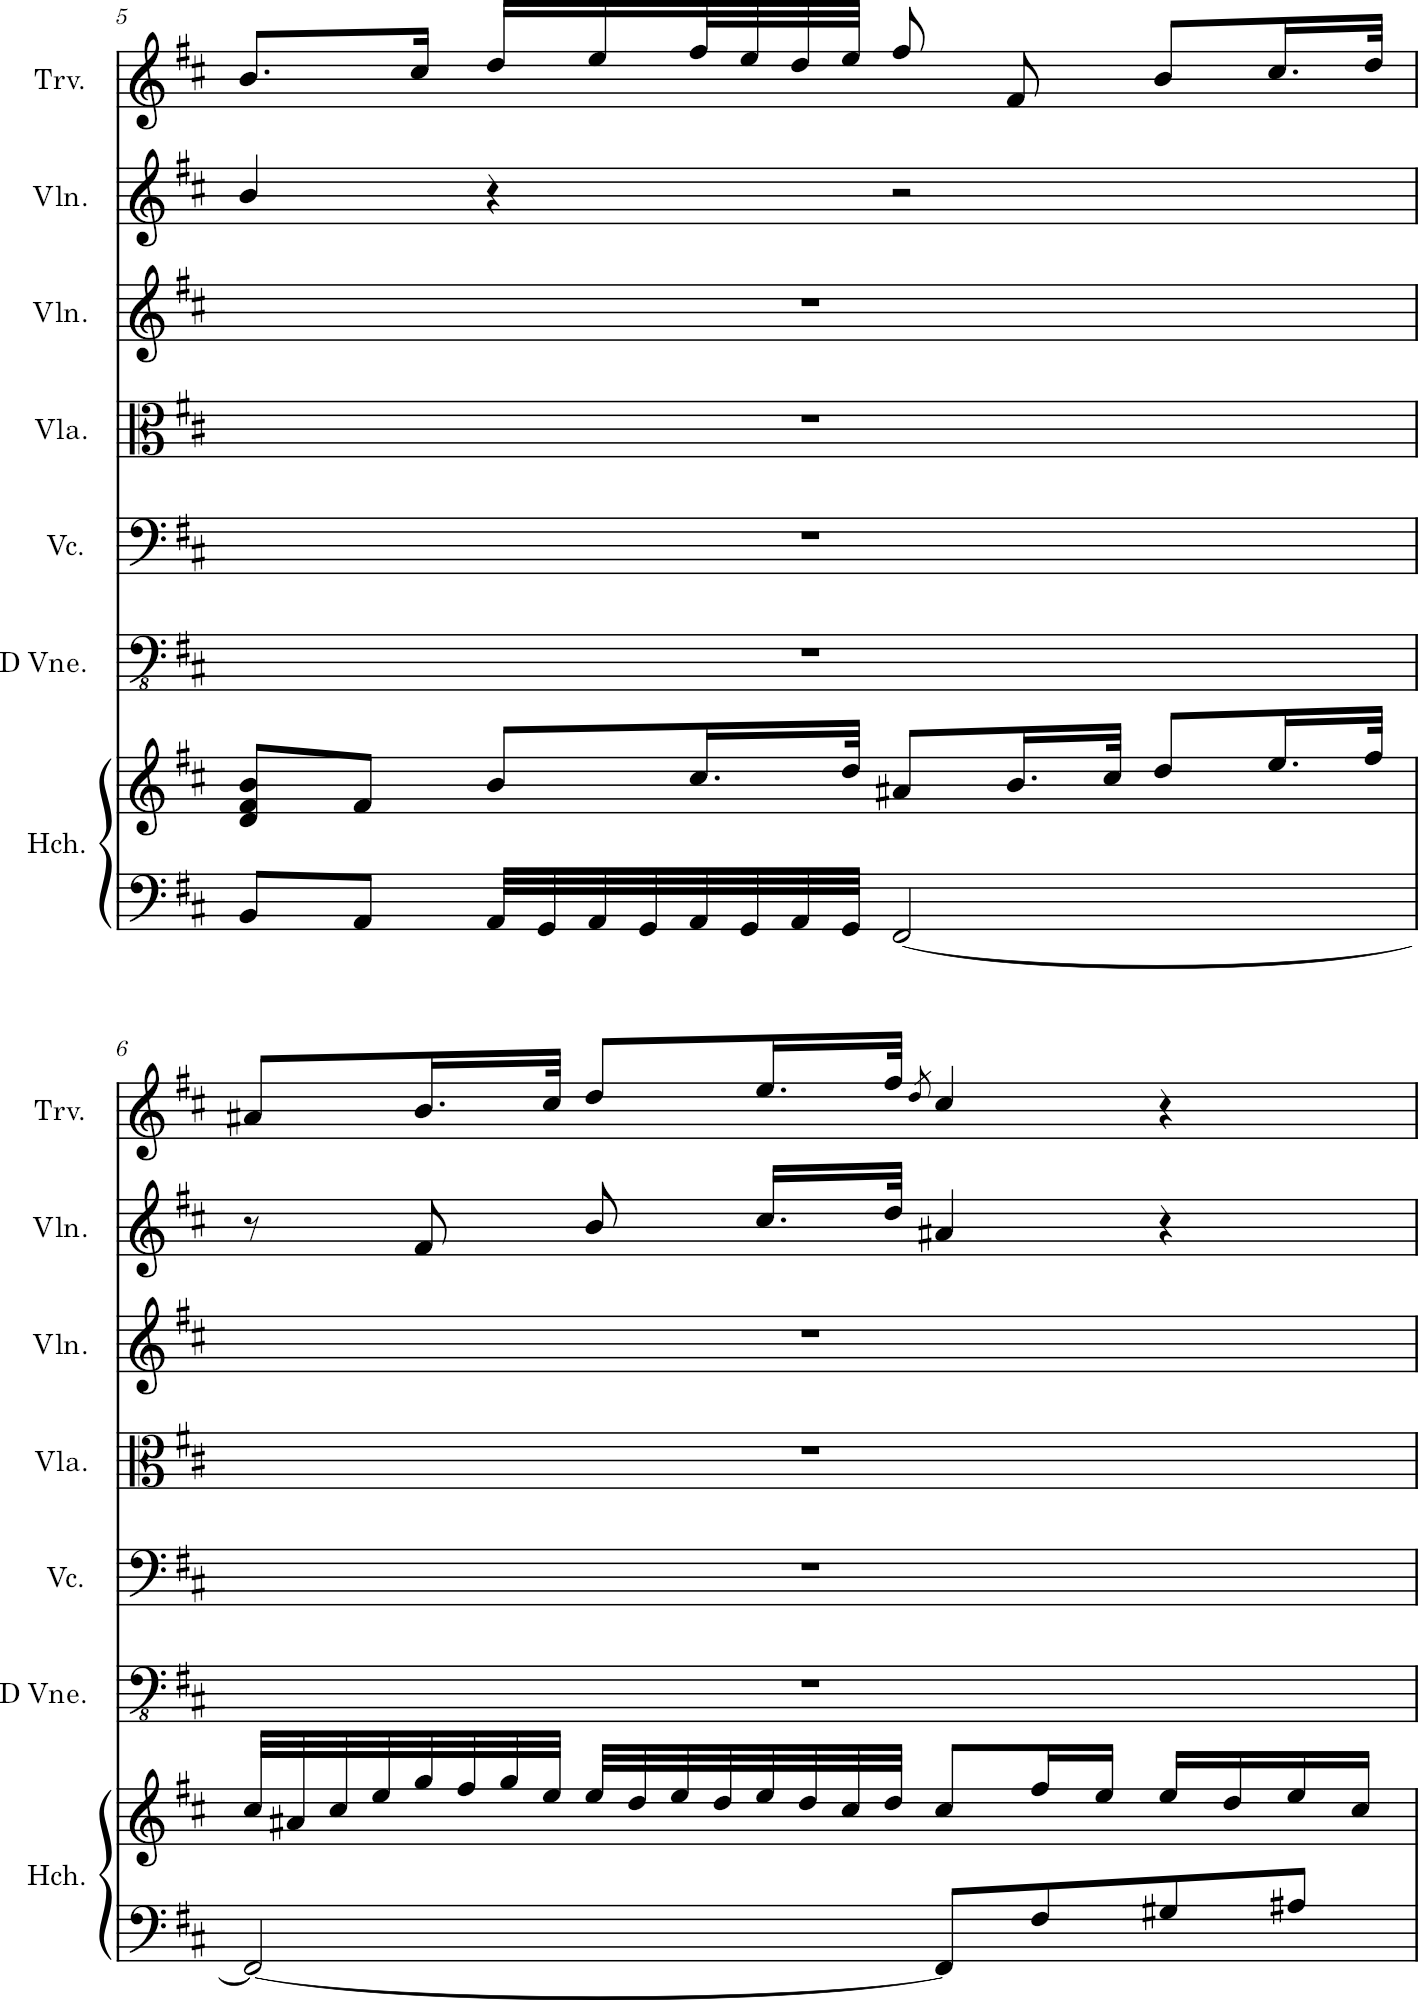

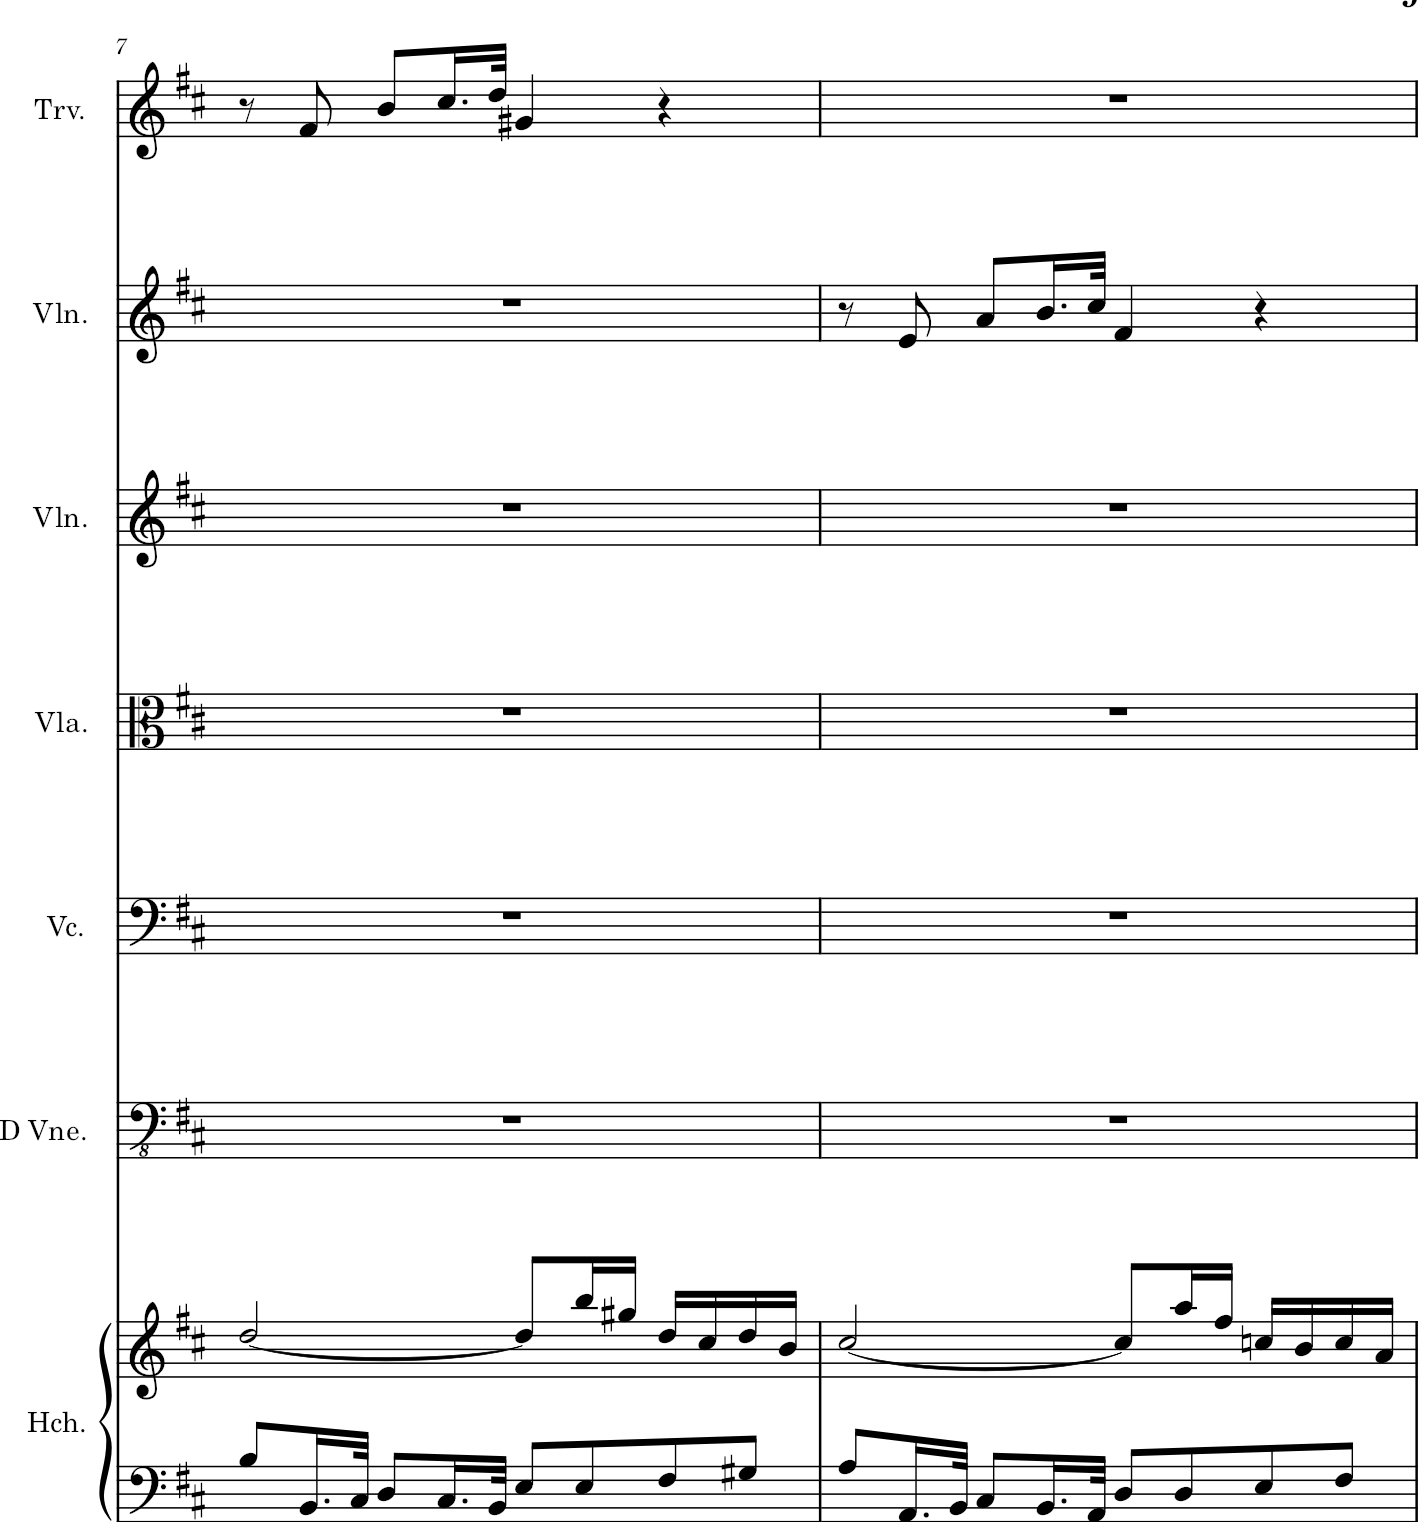

In [14]:
score = converter.parse("../QmTVCXiYukF3UASskwpr5CxUt5RPWTYhQDe2ERSC36e1Zs.mxl").measures(1,10)
score.show()

In [15]:
score.flatten().notes.stream().show("midi")